# Preprocessing Dataset

## Imports

In [6]:
import os

import cv2 as cv
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

## Preprocess dataset

MapAI uses images of 500x500 pixels. This input wont work on a U-Net networks as when we are Max-pooling the results will be: 500->250->125->62->... This 62 will later then be sampled up to 124 which will be a mismatch with 125. For the U-Net part of the thesis we will therefore scale up the training, validation and test images to 512x512.
<br>
<br>
Due to class imbalance we will also remove images that contains less then a threshold of class 1.

In [7]:
def _mask_to_boundary(mask, dilation_ratio=0.02):
    """
    Convert binary mask to boundary mask.
    :param mask (numpy array, uint8): binary mask
    :param dilation_ratio (float): ratio to calculate dilation = dilation_ratio * image_diagonal
    :return: boundary mask (numpy array)
    """
    h, w = mask.shape
    img_diag = np.sqrt(h ** 2 + w ** 2)
    dilation = int(round(dilation_ratio * img_diag))
    if dilation < 1:
        dilation = 1
    # Pad image so mask truncated by the image border is also considered as boundary.
    new_mask = cv.copyMakeBorder(mask, 1, 1, 1, 1, cv.BORDER_CONSTANT, value=0)
    kernel = np.ones((3, 3), dtype=np.uint8)
    new_mask_erode = cv.erode(new_mask, kernel, iterations=dilation)
    mask_erode = new_mask_erode[1 : h + 1, 1 : w + 1]
    # G_d intersects G in the paper.
    return mask - mask_erode

In [ ]:
# Defining sets that has to be rescaled
datasets = ['train', 'validation', 'task1_test']

# Define image size
original_size = 500
new_size = 512

for dataset in tqdm(datasets):
    # Make directory for preprocessed dataset
    dataset_path = os.path.normpath('dataset/MapAI/512x512_' + dataset)
    if not os.path.exists(dataset_path):
        os.makedirs(dataset_path)

    # Make directory for preprocessed subsets
    mask_path = os.path.normpath('dataset/MapAI/512x512_' + dataset + '/mask')
    image_path = os.path.normpath('dataset/MapAI/512x512_' + dataset + '/image')
    edge_mask_path = os.path.normpath('dataset/MapAI/512x512_' + dataset + '/edge_mask')
    original_mask_path = os.path.normpath('dataset/MapAI/' + dataset + '/mask')
    original_image_path = os.path.normpath('dataset/MapAI/' + dataset + '/image')
    
    if not os.path.exists(mask_path):
        os.makedirs(mask_path)
    if not os.path.exists(image_path):
        os.makedirs(image_path)
    if not os.path.exists(edge_mask_path):
        os.makedirs(edge_mask_path)

    # Upscale images to 512x512
    with os.scandir(original_mask_path) as entries:
        for entry in entries:
            mask_img = cv.imread(os.path.normpath(original_mask_path + '/' + entry.name), cv.IMREAD_GRAYSCALE)
            mask_img[mask_img == 255] = 1

            # Resize images
            # Mask
            resize_mask_img = cv.resize(mask_img, (new_size, new_size), interpolation = cv.INTER_AREA)
            cv.imwrite(os.path.normpath(mask_path + '/' + entry.name), resize_mask_img)
            
            # Edge mask
            edge_mask = _mask_to_boundary(resize_mask_img)
            edge_mask[edge_mask == 255] = 1
            cv.imwrite(os.path.normpath(edge_mask_path + '/' + entry.name), edge_mask)

            # Image
            img = cv.imread(os.path.normpath(original_image_path + '/' + entry.name), cv.IMREAD_COLOR)
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            resize_img = cv.resize(img, (new_size, new_size), interpolation = cv.INTER_AREA)
            resize_img = cv.cvtColor(resize_img, cv.COLOR_BGR2RGB)
            cv.imwrite(os.path.normpath(image_path + '/' + entry.name), resize_img)
            


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

In [4]:
# Displaying images before and after resizing
def show_images(set_name, data_name):
    path_original = os.path.normpath('dataset/MapAI/' + set_name)
    path_new = os.path.normpath("dataset/MapAI/512x512_" + set_name)
    # Define plot
    plt.figure(figsize=(20,20))
    
    # Find and display aerial image
    plt.subplot(231)
    plt.title('Aerial Image')
    aerial_img = cv.imread(os.path.normpath(path_new + "/image/" + data_name + ".PNG"))
    aerial_img = cv.cvtColor(aerial_img, cv.COLOR_BGR2RGB)
    plt.imshow(aerial_img)
    
    # Find and display mask image
    plt.subplot(232)
    plt.title('Mask Image')
    mask_img = cv.imread(os.path.normpath(path_new + "/mask/" + data_name + ".PNG"))
    plt.imshow(mask_img * 255, cmap='gray')
    
    # Find and display edge mask image
    plt.subplot(233)
    plt.title('Edge Mask Image')
    edge_mask_img = cv.imread(os.path.normpath(path_new + "/edge_mask/" + data_name + ".PNG"))
    plt.imshow(edge_mask_img * 255, cmap='gray')

    
    plt.show()

error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


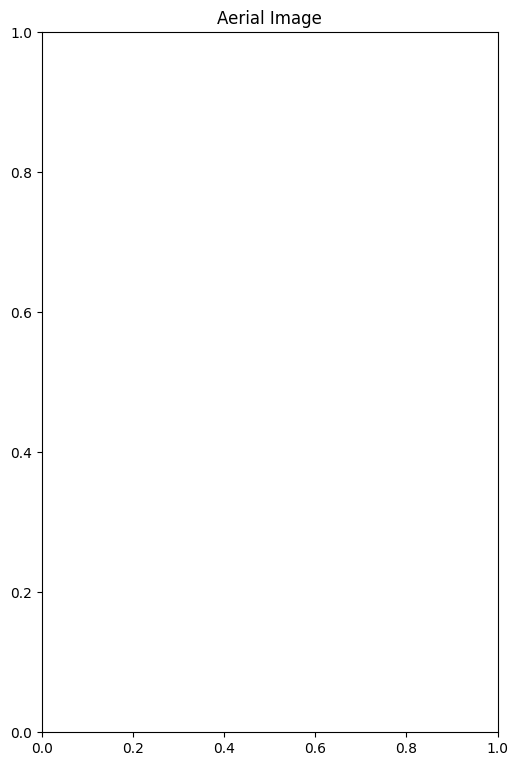

In [5]:
show_images("train", "6051_689_1")